# EXO 2

In [1]:
import numpy as np
import pylab
import healpy as hp
import pysm3 
import pysm3.units as u
import matplotlib.pyplot as py
import cmbdb as cmb
from fgbuster.mixingmatrix import MixingMatrix
from fgbuster.component_model import CMB, Dust, Synchrotron

In [2]:
from fgbuster.separation_recipes import basic_comp_sep

In [3]:
from fgbuster.observation_helpers import get_instrument,get_noise_realization,get_sky,get_observation

In [4]:
from fgbuster.cosmology import _get_Cl_noise

In [8]:
amin2rad = np.pi/(60.*180.)

# Simulating Sky

In [5]:
NSIDE = 64
lmax = 3*NSIDE-1  # Maximum ell value based on the given NSIDE value
sky_d0s0 = get_sky(NSIDE, 'd0s0')  # Get the sky map using the specified NSIDE and sky type 'd0s0'

instrument = get_instrument('LiteBIRD')  # Get the instrument information for 'LiteBIRD'

freq_maps_d0s0 = get_observation(instrument, sky_d0s0)
# Obtain the frequency maps for the given instrument and sky map.
# freq_maps_d0s0 is a 3D array containing the observed maps for each frequency channel.

num_freq, ncomp, npix = freq_maps_d0s0.shape
# Retrieve the dimensions of the freq_maps_d0s0 array.
# - num_freq represents the number of frequency channels.
# - ncomp represents the number of components in the observed map.
# - npix represents the number of pixels in the observed map.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


#### Create CMB map from Planck 2018

In [31]:
cl_CMB_th = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_lensed_scalar.fits")

cl_CMB_crop_th = cl_CMB_th[:,:lmax+1]

np.random.seed(0)
map_CMB = hp.synfast(cl_CMB_th,nside=NSIDE,new = True)


In [32]:
cl_CMB6 = hp.anafast(map_CMB,lmax=lmax,alm = False)
cl_CMB = cl_CMB6[:4]
print(cl_CMB.shape)

(4, 192)


In [33]:
map_CMB_QU = map_CMB[1:3]
print(map_CMB_QU.shape)

(2, 49152)


#### Noise maps

In [34]:
freq_maps_simple_noiseless = np.array([np.add(map_CMB,map_d0s0) for map_d0s0 in freq_maps_d0s0])


np.random.seed(0)
freq_map_noise = get_noise_realization(NSIDE,instrument#,unit = 'uK_CMB'
                                       )



### No beam management $As+n$

In [35]:
As_p = freq_map_noise+freq_maps_simple_noiseless

#### Perfect beam 

In [36]:
instrument_null = get_instrument('LiteBIRD')
instrument_null.fwhm = [0 for fwhm in instrument_null.fwhm]

## Component separation

In [37]:
components = [CMB(), Dust(353.), Synchrotron(23.)]
# The starting point of the fit is the ax1sm default value, so let's shift it
components[1].defaults = [1.54, 20.]
components[2].defaults = [-3.0]
A = MixingMatrix(*components)
A_ev = A.evaluator(instrument.frequency)
i_cmb = A.components.index('CMB')

In [38]:

result_0 = basic_comp_sep(components,instrument_null,As_p[:,1:3,:])

### Get noise

In [39]:
A_0  = A_ev(result_0.x)

In [40]:
cl_0 = _get_Cl_noise(instrument=instrument_null,A = A_0,lmax=lmax)[i_cmb, i_cmb, :]

/home/julientang2001/fgbuster/fgbuster/cosmology.py:742: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = (bl / np.radians(instrument.depth_p/60.)[:, np.newaxis])**2


In [41]:
inputs = [sky_d0s0.components[0].mbb_index,
          sky_d0s0.components[0].mbb_temperature.value,
          sky_d0s0.components[1].pl_index]
print('Basic component separation on $\dfrac{1}{B^\\nu}\\times (BAs+n)$')

print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))

for param, val, ref in zip(result_0.params, result_0.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))
print('Basic component separation on $As+n$')
print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
for param, val, ref in zip(result_0.params, result_0.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))


Basic component separation on $\dfrac{1}{B^\nu}\times (BAs+n)$
                    	Estimated	Input
Dust.beta_d         	1.540346	1.540000
Dust.temp           	19.993661	20.000000
Synchrotron.beta_pl 	-3.000970	-3.000000
Basic component separation on $As+n$
                    	Estimated	Input
Dust.beta_d         	1.540346	1.540000
Dust.temp           	19.993661	20.000000
Synchrotron.beta_pl 	-3.000970	-3.000000


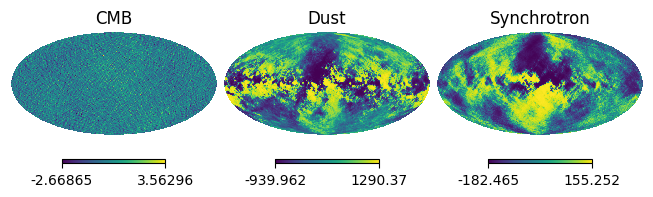

In [42]:
hp.mollview(result_0.s[0,1], title='CMB', sub=(1,3,1))
hp.mollview(result_0.s[1,1], title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(result_0.s[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))


# Residuals

In [43]:
res_CMB_0= np.zeros((3,npix),dtype=complex)
res_CMB_0[1:3] = result_0.s[0,0:2]-map_CMB_QU[0:2]
print(res_CMB_0.shape)

(3, 49152)


In [44]:
Cl_res_CMB = hp.anafast(res_CMB_0,lmax = lmax,alm=False,pol=True)

/home/julientang2001/.local/lib/python3.10/site-packages/healpy/sphtfunc.py:274: ComplexWarning: Casting complex values to real discards the imaginary part
  alms = _sphtools.map2alm(


### Retrieved CMB Power spectrum

In [45]:
res_ret_0 = np.zeros((3,npix),dtype=complex)
res_ret_0[1:3] = result_0.s[0]

In [46]:
C_l_ret_0 = hp.anafast(res_ret_0,alm=False,pol=True)

# + Gravitational waves

In [47]:
cl_GW = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits")
print(cl_GW.shape)
cl_GW_crop = cl_GW[:,:lmax+1]
print(cl_GW_crop.shape)

map_CMB = hp.synfast(cl_GW,nside=NSIDE)

(4, 4101)
(4, 192)


In [48]:
cl_tot_th = np.add(0.001*cl_GW_crop,cl_CMB)

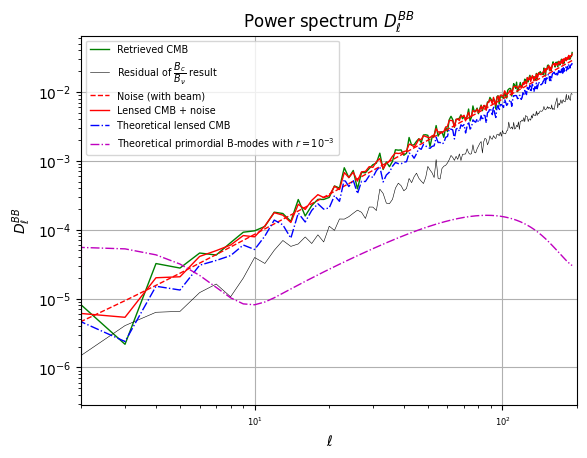

In [49]:
l_arr = np.arange(0,lmax+1,1)

py.figure(1)
ax1 = py.subplot(111)
ax1.tick_params('x', labelsize=6)


ax1.plot(l_arr,l_arr*(l_arr+1)*C_l_ret_0[2]/np.pi,'g',linewidth = 1,label = 'Retrieved CMB')
ax1.plot(l_arr,l_arr*(l_arr+1)*Cl_res_CMB[2]/np.pi,'k',linewidth =.4,label = 'Residual of $\dfrac{B_c}{B_{\\nu}}$ result')
ax1.plot(l_arr,l_arr*(l_arr+1)*cl_0,'r--',linewidth =1, label = 'Noise (with beam)')
ax1.plot(l_arr,l_arr*(l_arr+1)*(cl_CMB[2]+cl_0)/np.pi,'r-',linewidth =1,label = "Lensed CMB + noise")
py.title('Power spectrum $D_{\ell}^{BB}$ ')
ax1.plot(l_arr,l_arr*(l_arr+1)*cl_CMB[2]/np.pi,'b-.',linewidth =1,label = "Theoretical lensed CMB  ")
ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[2],'m-.',linewidth =1,label = "Theoretical primordial B-modes with $r=10^{-3}$")


handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2)
py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")


py.ylabel('$D_{\ell}^{BB}$')  
py.legend(handles,labels, loc = 'upper left', fontsize = 'x-small')
py.show()

# Cosmological parameters (to be modified)

In [50]:
def cosmo_likelihood(r,C_l_obs,noise):
    if len(C_l_obs)!=lmax+1 or len(noise)!=lmax+1:
        raise Warning("Arrays should be of size "+str(lmax))
    
    C_lth =r*cl_GW_crop[2]+cl_CMB_crop_th[2]+noise
    sig = 0
    for l in range(2,lmax):
        sig+=(2*l+1)*(np.log(C_lth[l])+C_l_obs[l]/C_lth[l])
    return (sig)


In [51]:
avg_cosmo_ren = cosmo_likelihood(r=0,C_l_obs=C_l_ret_ren_BB,noise=cl_beam_ren)
avg_cosmo_inv = cosmo_likelihood(r=0,C_l_obs=C_l_inv_BB,noise=cl_beam_inv)

print(avg_cosmo_ren)

NameError: name 'C_l_ret_ren_BB' is not defined

In [ ]:
r_arr = np.logspace(-2.3,-2,100)
y_ren =np.array([cosmo_likelihood(r,C_l_obs=C_l_ret_ren_BB,noise=cl_beam_ren) for r in r_arr])
y_inv =np.array([cosmo_likelihood(r,C_l_obs=C_l_inv_BB,noise=cl_beam_inv) for r in r_arr])
y_inv0 = np.min(y_inv)

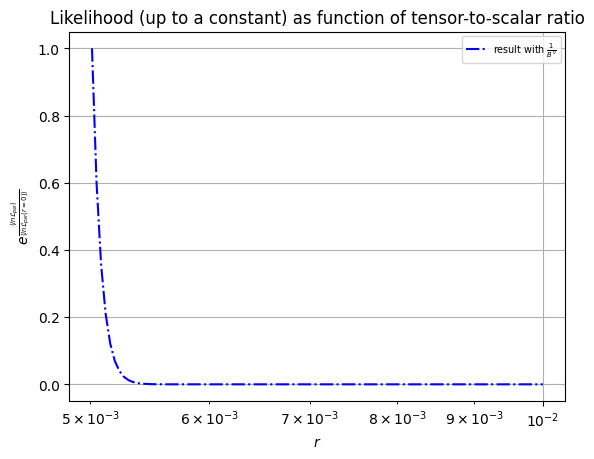

In [ ]:
fig,ax = py.subplots()

# ax.plot(r_arr,np.exp((avg_cosmo_ren-y_ren)/2),'r-.', label = 'result with '+r'$\frac{B^c}{B^{\nu}}$')
ax.plot(r_arr,np.exp((y_inv0-y_inv)/2),'b-.',label = 'result with '+r'$\frac{1}{B^{\nu}}$')



py.title('Likelihood (up to a constant) as function of tensor-to-scalar ratio')
handles, labels = ax.get_legend_handles_labels()
py.xlabel(r'$r$')
py.ylabel(r'$e^{\frac{\langle ln \mathcal{L}_{par} \rangle}{\langle ln \mathcal{L}_{par}(r=0) \rangle}}$')

# py.ylabel(r'$e^{-1+\frac{\langle ln \mathcal{L}_{par} \rangle}{\langle ln \mathcal{L}_{par}(r=0) \rangle}}$')
# py.yscale("log")
py.xscale("log")
# py.xlim(0,1e-3)
py.grid()
# py.ylim(-1,1)

        #  of the residuals with and without beam, with noise')
# Set the background color of the plot
# ax.set_facecolor('gray')

# Set the background color of the figure
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# ax.title.set_color('white')
# fig.set_facecolor('gray')

py.legend(handles,labels, loc = 'best', fontsize = 'x-small')
py.show()